In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import re
import gc
import glob
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.optimizers import Adam,SGD
from keras import backend as K
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
import datetime
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input,Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D

C:\Users\MY\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
os.listdir("D:\Pneumonia Detection\Chest X-Ray")

['test', 'train', 'val']

In [6]:
base = "D:\Pneumonia Detection\Chest X-Ray"
train = os.path.join(base, 'train')
val = os.path.join(base, 'val')
test = os.path.join(base, 'test')

In [7]:
n_dir = os.path.join(train, 'NORMAL')
n_imgs = os.listdir(n_dir)
len(n_imgs)

1341

In [8]:
p_dir = os.path.join(train, 'PNEUMONIA')
p_imgs = os.listdir(p_dir)
len(p_imgs)

3875

In [9]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}'.format(indent, os.path.basename(root)), '-', len(os.listdir(root)))
        
folder = "E:\Pneumonia Detection\Chest X-Ray"
list_files(folder)

Chest X-Ray - 3
    test - 2
        NORMAL - 234
        PNEUMONIA - 390
    train - 2
        NORMAL - 1341
        PNEUMONIA - 3875
    val - 2
        NORMAL - 8
        PNEUMONIA - 8


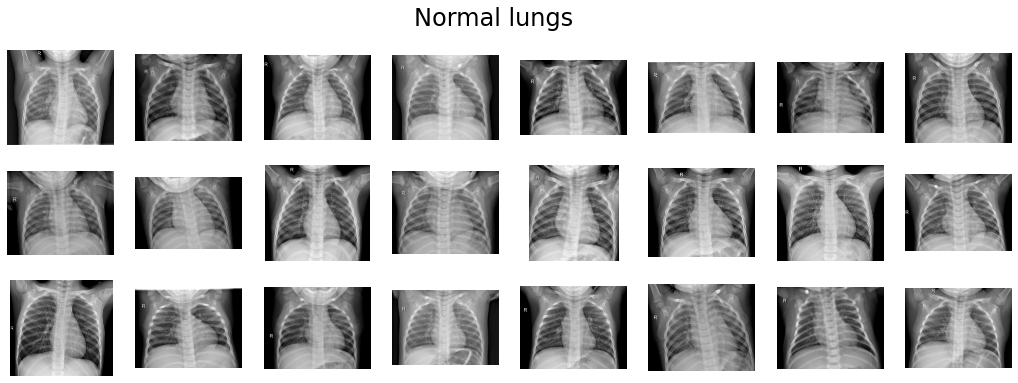

In [10]:

fig, ax = plt.subplots(figsize=(18, 6))
fig.suptitle('Normal lungs', fontsize=24)

for i, img_path in enumerate(n_imgs[:24]):
    plt.subplot(3, 8, i+1)
    img = cv2.imread(os.path.join(n_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
plt.show()

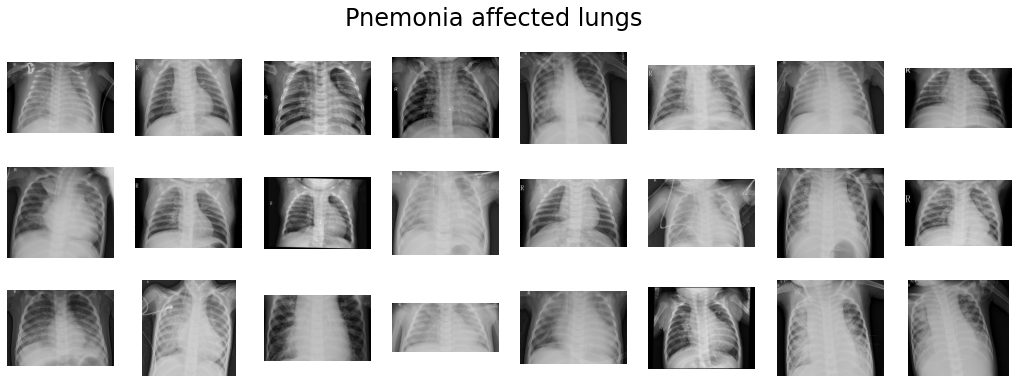

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
fig.suptitle('Pnemonia affected lungs', fontsize=24)

for i, img_path in enumerate(p_imgs[:24]):
    plt.subplot(3, 8, i+1)
    img = cv2.imread(os.path.join(p_dir, img_path))
    plt.axis('off')
    plt.imshow(img)
plt.show()

In [12]:
def bar_plot(dir):
  x=len(os.listdir(dir+'/NORMAL'))
  y=len(os.listdir(dir+'/PNEUMONIA'))
  category = ['NORMAL', 'PNEUMONIA']
  count = [x, y]
  plot = plt.bar(category,count) 
  plot[0].set_color('orange')
  plt.title('Plot of number of values for each category')
  plt.show()

Training images:

NORMAL: 1341
PNEUMONIA: 3875
Total Training images: 5216
*************************************************


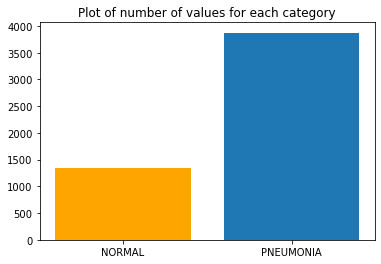

In [13]:
print('Training images:\n')
print('NORMAL:', len(os.listdir(train+'/NORMAL')))
print('PNEUMONIA:', len(os.listdir(train+'/PNEUMONIA')))
print('Total Training images:', len(os.listdir(train+'/NORMAL')) + len(os.listdir(train+'/PNEUMONIA')))
print('*'*49)

bar_plot(train)

Validation images:

NORMAL: 8
PNEUMONIA: 8
Total Validation images: 16
***********************************************


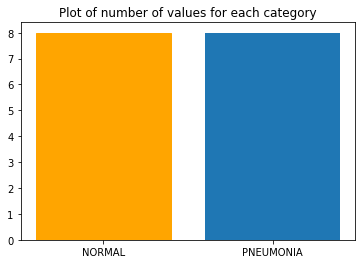

In [14]:
print('Validation images:\n')
print('NORMAL:', len(os.listdir(val+'/NORMAL')))
print('PNEUMONIA:', len(os.listdir(val+'/PNEUMONIA')))
print('Total Validation images:', len(os.listdir(val+'/NORMAL')) + len(os.listdir(val+'/PNEUMONIA')))
print('*'*47)

bar_plot(val)

Test images:

NORMAL: 234
PNEUMONIA: 390
Total Test images: 624
*************************************************


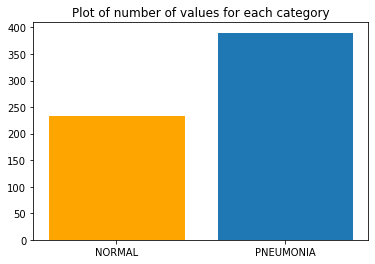

In [15]:
print('Test images:\n')
print('NORMAL:', len(os.listdir(test+'/NORMAL')))
print('PNEUMONIA:', len(os.listdir(test+'/PNEUMONIA')))
print('Total Test images:', len(os.listdir(test+'/NORMAL')) + len(os.listdir(test+'/PNEUMONIA')))
print('*'*49)

bar_plot(test)

In [16]:
for file in os.listdir(train):
  if file=='.DS_Store':
    os.remove(os.path.join(train,file))
    
for file in os.listdir(val):
  if file=='.DS_Store':
    os.remove(os.path.join(val,file))

for file in os.listdir(test):
  if file=='.DS_Store':
    os.remove(os.path.join(test,file))

In [17]:
list_of_heights = []
list_of_widths = []
for i in os.listdir(train):
    for image in os.listdir(os.path.join(train,i)):
      if image.endswith('.jpeg'):
        img = cv2.imread(os.path.join(os.path.join(train,i),image), cv2.IMREAD_UNCHANGED)
        shape = img.shape
        list_of_heights.append(shape[0])
        list_of_widths.append(shape[1])

Height of images:

Median: 888.0
Mean: 968.0747699386503


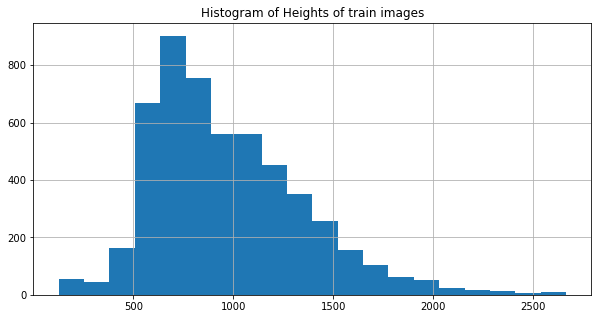

In [18]:
%matplotlib inline

print('Height of images:\n')
print('Median:',np.median(list_of_heights))
print('Mean:',np.mean(list_of_heights))

plt.figure(figsize=(10,5))
plt.hist(list_of_heights,bins=20)
plt.title('Histogram of Heights of train images')
plt.grid()
plt.show()

Width of images:

Median: 1284.0
Mean: 1320.6108128834355


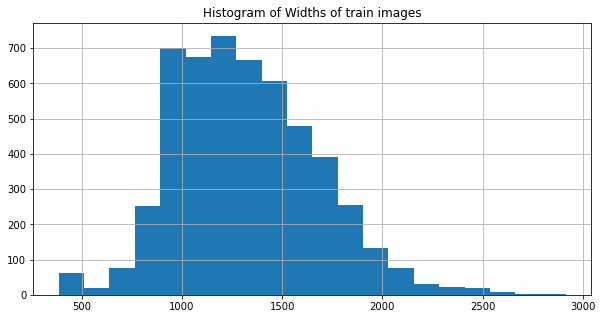

In [19]:
print('Width of images:\n')
print('Median:',np.median(list_of_widths))
print('Mean:', np.mean(list_of_widths))

plt.figure(figsize=(10,5))
plt.hist(list_of_widths,bins=20)
plt.title('Histogram of Widths of train images')
plt.grid()
plt.show()

In [21]:
def plot_performance_metrics(model):
  tr_loss = model.history['loss']
  val_loss = model.history['val_loss']

  tr_prec = model.history['precision_m'] 
  val_prec = model.history['val_precision_m']

  tr_recall = model.history['recall_m']   
  val_recall = model.history['val_recall_m'] 

  tr_f1 = model.history['f1_m']
  val_f1 = model.history['val_f1_m']

  fig, axs = plt.subplots(2, 2, figsize=(15,15))
  plt.subplots_adjust(hspace=0.40)
  
  for ax in axs.flat:
    ax.set(xlabel='\nEpochs')
      
  # Loss Plot
  axs[0,0].plot(tr_loss)
  axs[0,0].plot(val_loss)
  axs[0,0].grid()
  axs[0,0].legend(['Train Loss', 'Test Loss'], loc='upper left')
  axs[0,0].set_title('Plot of Train and Test Loss against Epochs')

  # Precision Plot
  axs[0,1].plot(tr_prec)
  axs[0,1].plot(val_prec)
  axs[0,1].grid()
  axs[0,1].legend(['Train Precision', 'Test Precision'], loc='upper left')
  axs[0,1].set_title('Plot of Train and Test Precision against Epochs')

  # Recall Plot
  axs[1,0].plot(tr_recall)
  axs[1,0].plot(val_recall)
  axs[1,0].grid()
  axs[1,0].legend(['Train Recall', 'Test Recall'], loc='upper left')
  axs[1,0].set_title('Plot of Train and Test Recall against Epochs')

  # F1-Score Plot
  axs[1,1].plot(tr_f1)
  axs[1,1].plot(val_f1)
  axs[1,1].grid()
  axs[1,1].legend(['Train F1-Score', 'Test F1-Score'], loc='upper left')
  axs[1,1].set_title('Plot of Train and Test F1-Score against Epochs')
  
  #fig.delaxes(axs[2,1])

  plt.show()

In [22]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
# Prediction function for sigmoid.
def predict_classes(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0  # if result has probability less than or equal to 0.5 then the label is 0.
    valResult[valResult > 0.5] = 1   # if result has probability greater than 0.5 then the label is 1.
    return valResult

# Function for Confusion Matrix.
def plot_confusion_matrix(predictions, labels):
    valResult = predict_classes(predictions)
    conf_matrix_df = pd.DataFrame(confusion_matrix(labels, valResult),
                                  index=["Normal", "Pneumonia"],
                                  columns=["Normal", "Pneumonia"])
    plt.figure(figsize=(7,6))
    plt.title("Confusion Matrix")
    sns.heatmap(conf_matrix_df, annot=True, annot_kws={"size" : "20"}, fmt='.4g')
    plt.xlabel('\nPredicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12, rotation='horizontal', labelpad=40)

    # Get TP, FP, TN and FN
    cm = confusion_matrix(labels, valResult) 
    print('='*50)                                
    print('True Positive  (TP) = ', cm[0][0])
    print('False Positive (FP) = ', cm[0][1])
    print('False Negative (FN) = ', cm[1][0])
    print('True Negative  (TN) = ', cm[1][1])
    print('-'*26)

    # Get Precision, Recall and F1 Score.
    if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
      precision = round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
      recall    = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
      f1_score  = round(2*((precision*recall)/(precision+recall)), 2)       
      print(f'Precision Score: {precision}%')
      print(f'Recall Score: {recall}%')
      print(f'F1 Score: {f1_score}%')
      print('='*50) 
      print('\n')

# Function for ROC curve.
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions) # FPR, TPR and Threshold of ROC curve.
    auc = roc_auc_score(validation_generator.classes, prediction) # AUC Score.
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g',label = 'AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('\nTrue Positive Rate (TPR)', fontsize=12)
    plt.xlabel('\nFalse Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
batch_size = 16
width = 224
height = 224

In [25]:
model = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(width, height, 1)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dropout(0.5),
    
    Dense(512, activation=relu),
    Dropout(0.5),
    
    Dense(512, activation=relu),
    Dense(1, activation=sigmoid)
])

# Compiling the model.
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[recall_m,precision_m,f1_m]) 

# Summary of Architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [26]:
trainDataGen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 9,
                                  zoom_range = 0.2,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2) 

validationDataGen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 9,
                                       zoom_range = 0.2,
                                       width_shift_range = 0.2,
                                       height_shift_range = 0.2) 

# Train  
train_generator = trainDataGen.flow_from_directory(train,
                                                   target_size = (width, height),
                                                   batch_size = batch_size,
                                                   class_mode = 'binary',
                                                   color_mode = 'grayscale')
# Test
validation_generator = validationDataGen.flow_from_directory(test,
                                                             target_size = (width, height),
                                                             batch_size = batch_size,
                                                             class_mode = 'binary',
                                                             color_mode = 'grayscale',
                                                             shuffle = False)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [27]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
# Clear logs, if any, from previous runs.
# !rm -rf ./logs/ 
# Storing the event files in 'logs/Model_1_' folder.
log_dir="logs/Model_1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

# EarlyStopping.
earlyStopping = EarlyStopping(
    monitor='val_recall_m',
    mode='max', 
    baseline=None, 
    restore_best_weights=True, 
    patience = 8,
    verbose = 1
)

# Defining train and val steps required during model fitting.
validation_steps = validation_generator.samples // batch_size   # (624/16 = 39)
training_steps = train_generator.samples // batch_size          # (5216/16= 326)


# Fit the model.
model_1 = model.fit_generator(generator = train_generator,
                              steps_per_epoch = training_steps, # 326
                              epochs = 20,
                              validation_data = validation_generator,
                              validation_steps = validation_steps, # 39
                              callbacks = [tensorboard_callback,earlyStopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
326/326 [==============================] - 533s 2s/step - loss: 0.4374 - recall_m: 0.9328 - precision_m: 0.8140 - f1_m: 0.8567 - val_loss: 0.4535 - val_recall_m: 0.5118 - val_precision_m: 0.6368 - val_f1_m: 0.5656
Epoch 2/20
326/326 [==============================] - 503s 2s/step - loss: 0.3262 - recall_m: 0.8920 - precision_m: 0.9149 - f1_m: 0.8962 - val_loss: 0.4587 - val_recall_m: 0.5823 - val_precision_m: 0.6337 - val_f1_m: 0.6059
Epoch 3/20
326/326 [==============================] - 490s 2s/step - loss: 0.2885 - recall_m: 0.9000 - precision_m: 0.9306 - f1_m: 0.9090 - val_loss: 0.3735 - val_recall_m: 0.5582 - val_precision_m: 0.6337 - val_f1_m: 0.5924
Epoch 4/20
326/326 [==============================] - 487s 1s/step - loss: 0.2701 - recall_m: 0.9048 - precision_m: 0.9375 - f1_m: 0.9161 - val_loss: 0.5468 - val_recall_m: 0.5935 - val_precision_m: 0.6314 - val_f1_m: 0.6104
Epoch 5/20
326/326 [====

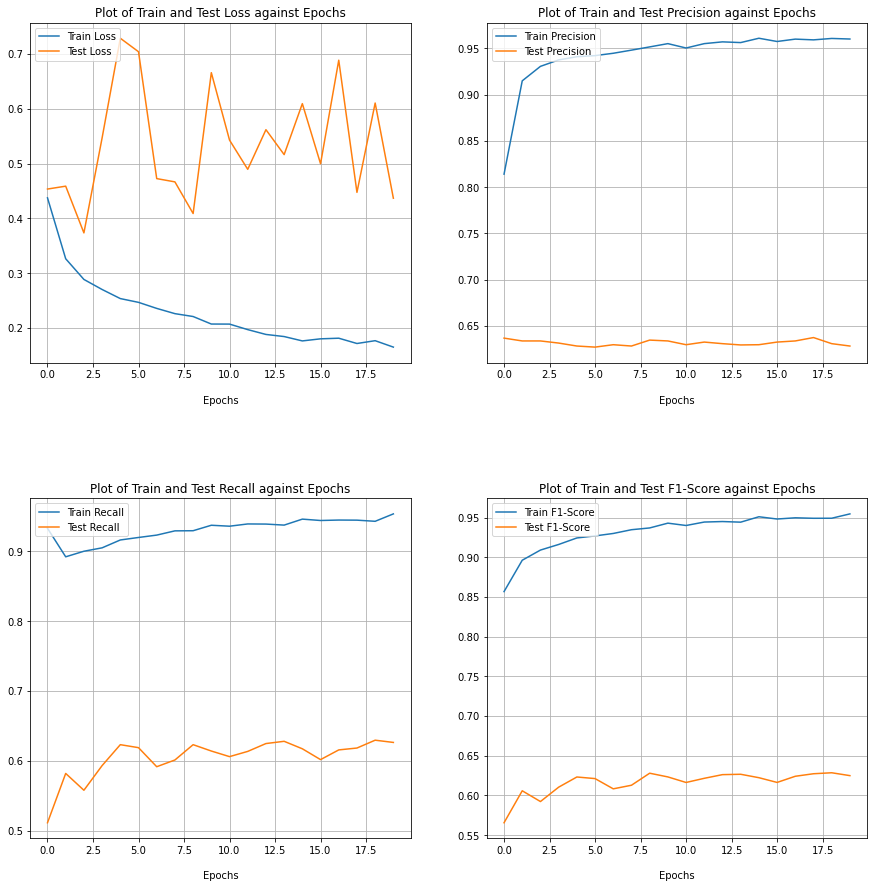

In [30]:
plot_performance_metrics(model_1)

In [33]:
# Final prediction of test images.
prediction = model.predict_generator(validation_generator, validation_steps)
actual_class = validation_generator.classes

True Positive  (TP) =  134
False Positive (FP) =  100
False Negative (FN) =  8
True Negative  (TN) =  382
--------------------------
Precision Score: 57.26%
Recall Score: 94.37%
F1 Score: 71.27%




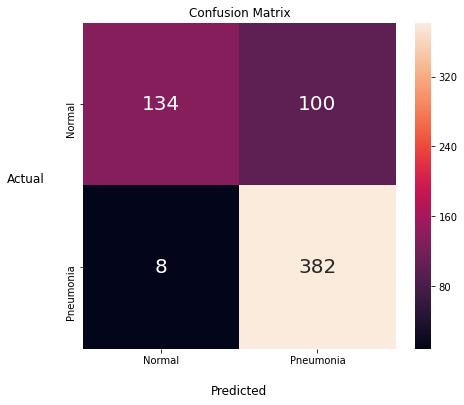

In [34]:
# Confusion Matrix.
plot_confusion_matrix(prediction, actual_class)

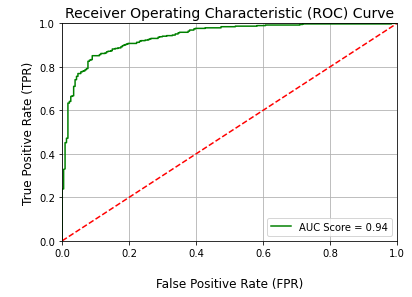


 Classification Report: 

               precision    recall  f1-score   support

      Normal       0.94      0.57      0.71       234
   Pneumonia       0.79      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.78      0.79       624
weighted avg       0.85      0.83      0.81       624



In [35]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, 
                                                              predict_classes(prediction), 
                                                              target_names = ["Normal", "Pneumonia"]))
print('='*55)
